In [1]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 4
time_steps = 101
category = 2
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Using TensorFlow backend.


In [2]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [22]:
file_read = open("../imgtvgene_sequence_classification/mem.txt")

source_sequence = []
target_sequence = []

cluster_tag = []
cluster_dic = {}
classes = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0
max_count = 200000

max_source = 0
max_target = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    if not split[1] in cluster_dic:
        classes += 1
        cluster_dic[split[1]] = classes
    cluster_tag.append(split[1])
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source < len(source):
        max_source = len(source)
    
    target = [char_to_int[x] for x in split[-2][1:-1]]
    target_sequence.append(target)
    if max_target < len(target):
        max_target = len(target)
    
    vgene_name = split[-1][1:-1]#.split("*")[0]
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    
    #print(split[1], vgene_name)
    if count == max_count:
        break
"""    
source_sequence = np.array(source_sequence)
target_sequence = np.array(target_sequence)

cluster_tag = np.array(cluster_tag)
vgene_tag = np.array(vgene_tag)

print(source_sequence.shape, target_sequence.shape)
print(max_source, max_target)
print()
print(cluster_tag.shape, vgene_tag.shape)
print(classes, vgenes)
"""

'    \nsource_sequence = np.array(source_sequence)\ntarget_sequence = np.array(target_sequence)\n\ncluster_tag = np.array(cluster_tag)\nvgene_tag = np.array(vgene_tag)\n\nprint(source_sequence.shape, target_sequence.shape)\nprint(max_source, max_target)\nprint()\nprint(cluster_tag.shape, vgene_tag.shape)\nprint(classes, vgenes)\n'

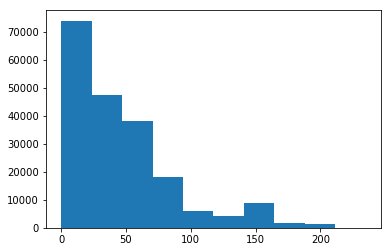

200000 200000


In [23]:
import matplotlib.pyplot as plt

plt.hist(vgene_tag)
plt.show()

print(len(source_sequence), len(target_sequence))

# Simple Test Layer

In [ ]:
model.add(Conv1D(64, 3, activation='relu', input_shape=(seq_length, 100)))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

In [24]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

max_source_len = 526
max_target_len = int(max_source_len/2)

source_sequence = pad_sequences(source_sequence, maxlen=max_source_len, value=0)
target_sequence = pad_sequences(target_sequence, maxlen=max_target_len, value=0)

print(source_sequence.shape, target_sequence.shape)

(200000, 526) (200000, 263)


In [6]:
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import UpSampling1D
import numpy as np

vocab_size = 5.
x_train = np.float32(source_sequence) / vocab_size
x_test = np.float32(target_sequence) / vocab_size
x_train = np.reshape(x_train, (len(x_train), max_source_len, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), max_target_len, 1))  # adapt this if using `channels_first` image data format

print(x_train.shape, x_test.shape)

(200000, 526, 1) (200000, 263, 1)


In [15]:
input_seq = Input(shape=(max_source_len, 1))  # adapt this if using `channels_first` image data format

conv_seq = Conv1D(32, 3, activation='relu', padding='same')(input_seq)
#pool_seq = MaxPooling1D(2, padding='same')(conv_seq)
#conv_seq = Conv1D(32, 3, activation='relu', padding='same')(pool_seq)
encoded = MaxPooling1D(2, padding='same')(conv_seq)

# at this point the representation is (7, 7, 32)

#conv_seq = Conv1D(32, 3, activation='relu', padding='same')(encoded)
#up_seq = UpSampling1D(2)(conv_seq)
#conv_seq = Conv2D(32, 3, activation='relu', padding='same')(up_seq)
#up_seq = UpSampling1D(2)(conv_seq)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(encoded)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

autoencoder.summary()

history = autoencoder.fit(x_train, x_test,
                epochs=5,
                batch_size=1000,
                shuffle=True)
                #validation_data=(x_test_noisy, x_test),
                #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 526, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 526, 32)           128       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 263, 32)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 263, 1)            97        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
200000/200000 [==============================] - 39s 193us/step - loss: 0.3438 - acc: 0.8265

# Map to Original Sequence

In [24]:
for i in range(0, max_count):
    randomized = np.random.randint(0, 5, size=len(source_sequence[i]))
    source_sequence.append(randomized)
    target_sequence.append(target_sequence[i])
    

In [25]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

max_source_len = 526
max_target_len = int(max_source_len/2)

source_sequence = pad_sequences(source_sequence, maxlen=max_source_len, value=0)
target_sequence = pad_sequences(target_sequence, maxlen=max_target_len, value=0)

print(source_sequence.shape, target_sequence.shape)


(400000, 526) (400000, 263)


In [27]:
shared_data_label = []
for i in range(len(source_sequence)):
    if i < int(len(source_sequence)/2):
        shared_data_label.append(1)
    else:
        shared_data_label.append(0)
shared_data_label = np.array(shared_data_label)
print(shared_data_label.shape, np.count_nonzero(shared_data_label))

(400000,) 200000


In [ ]:
#Denoising Sequence

In [30]:
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import UpSampling1D
import numpy as np


input_source = Input(shape=(max_source_len,), dtype='int32', name='input_source')
input_target = Input(shape=(max_target_len,), dtype='int32', name='input_target')
#batch_shape=(batch_size, time_steps), 

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, \
                            name="embedding")
embed_source = embedding_layer(input_source)

#embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, \
#                            name="embedding")
embed_target = embedding_layer(input_target)

lstm_layer_source_one = LSTM(units=128, stateful=False, \
                            return_sequences=True, unroll=False, name="lstm_one_source")
lstm_one_source = lstm_layer_source_one(embed_source)

lstm_layer_target_one = LSTM(units=128, stateful=False, \
                            return_sequences=True, unroll=False, name="lstm_one_target")
lstm_one_target = lstm_layer_target_one(embed_target)


lstm_layer_source_two = LSTM(units=128, stateful=False, \
                            return_sequences=False, unroll=False, name="lstm_two_source")
lstm_two_source = lstm_layer_source_two(lstm_one_source)

lstm_layer_target_two = LSTM(units=128, stateful=False, \
                            return_sequences=False, unroll=False, name="lstm_two_target")
lstm_two_target = lstm_layer_target_two(lstm_one_target)


element_wise_product = keras.layers.Multiply()([lstm_two_source, lstm_two_target])
dot_product = keras.layers.Dot(axes=1, normalize=True)([lstm_two_source, lstm_two_target])

# And add a logistic regression on top
predictions = Dense(1, activation='sigmoid', name="logistic")(element_wise_product)

# We define a trainable model linking the
# tweet inputs to the predictions
shared_model = Model(inputs=[input_source, input_target], outputs=predictions)

shared_model.compile(optimizer="adam", #optimizer='sgd',
              loss="binary_crossentropy", #loss='mean_squared_error',
              metrics=['acc'])
shared_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_source (InputLayer)       (None, 526)          0                                            
__________________________________________________________________________________________________
input_target (InputLayer)       (None, 263)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             24          input_source[0][0]               
                                                                 input_target[0][0]               
__________________________________________________________________________________________________
lstm_one_source (LSTM)          (None, 526, 128)     68096       embedding[0][0]                  
__________

In [ ]:
from keras_tqdm import TQDMNotebookCallback

print('Train...')
history = shared_model.fit([source_sequence, target_sequence], shared_data_label, 
        batch_size=batch_size*1, shuffle=True, epochs=10, verbose=2,
        callbacks=[TQDMNotebookCallback()])#, validation_data=(x_eval, y_eval))


Train...
Epoch 1/10
 - 6563s - loss: 0.1521 - acc: 0.9301
Epoch 2/10


dict_keys(['loss', 'acc'])


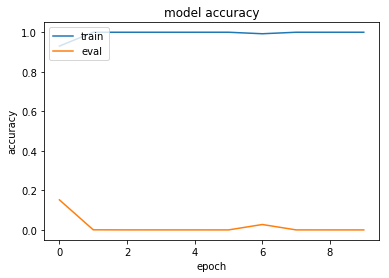

In [32]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Encoded Squence

In [35]:
file_read = open("../imgtvgene_sequence_classification/mem.txt")

source_sequence = []
max_count = 200000
max_source_len = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source_len < len(source):
        max_source_len = len(source)
    
    vgene_name = split[-1][1:-1].split("*")[0]
    #* for Gene /- for Family /No Split for Allele
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
print(len(source_sequence), max_source_len)
print(len(vgene_tag), vgenes)


200000 526
200000 63


In [37]:
x_data = pad_sequences(source_sequence, maxlen=max_source_len, value=0)
y_data = to_categorical(vgene_tag)
zeros = np.zeros((len(x_data), int(len(x_data[0])/2)))

print(x_data.shape, y_data.shape, zeros.shape)

(200000, 526) (200000, 63) (200000, 263)


In [ ]:

layer_name = "lstm_two_source"
intermediate_layer_model = Model(inputs=shared_model.input,
                                 outputs=shared_model.get_layer(layer_name).get_output_at(0))
intermediate_output = intermediate_layer_model.predict([x_data, zeros])

print(intermediate_output.shape)

# Classifying Sequences

In [44]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

train_index = int((len(x_data) / batch_size) * 0.80 * batch_size)
eval_index = train_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
test_index = eval_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
print("train, eval, test = ", (train_index, eval_index, test_index))

x_train = x_data[0:train_index]
y_train = y_data[0:train_index]

x_eval = x_data[train_index:eval_index]
y_eval = y_data[train_index:eval_index]

x_test = x_data[eval_index:test_index]
y_test = y_data[eval_index:test_index]

print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)
print(x_test.shape, y_test.shape)

train, eval, test =  (160000, 200000, 240000)
(160000, 526) (160000, 63)
(40000, 526) (40000, 63)
(0, 526) (0, 63)


In [49]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

print(intermediate_output.shape)
embedding_size = 4
lstm_unit = 8

input_source = Input(shape=(max_source_len,), \
                     dtype='float32', name='main_input')

dense_layer_first = Dense(2048, activation='relu', \
                        name='fstlayer')(input_source)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(1024, activation='relu', \
                        name='midlayer1')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer_mid = Dense(512, activation='relu', \
                        name='midlayer2')(dense_layer_mid)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(256, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(vgenes, activation='softmax', \
                     name='output')(dense_layer)

classify_model = Model(inputs=[input_source], outputs=[dense_output])
classify_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

classify_model.summary()

(200000, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 526)               0         
_________________________________________________________________
fstlayer (Dense)             (None, 2048)              1079296   
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
midlayer1 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
midlayer2 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0      

In [ ]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = classify_model.fit(x_train, y_train, \
          validation_data=(x_eval, y_eval), \
          epochs=200, shuffle=True, batch_size=1000, \
           callbacks=[TQDMNotebookCallback()], verbose=2)


Train...
Train on 160000 samples, validate on 40000 samples
Epoch 1/200
 - 26s - loss: 2.9825 - acc: 0.2092 - val_loss: 1.9909 - val_acc: 0.4094
Epoch 2/200
 - 24s - loss: 1.5416 - acc: 0.5153 - val_loss: 1.1329 - val_acc: 0.6071
Epoch 3/200
 - 24s - loss: 1.0459 - acc: 0.6545 - val_loss: 0.8482 - val_acc: 0.7137
Epoch 4/200
 - 24s - loss: 0.8572 - acc: 0.7138 - val_loss: 0.7116 - val_acc: 0.7592
Epoch 5/200
 - 23s - loss: 0.7693 - acc: 0.7434 - val_loss: 0.6355 - val_acc: 0.7792
Epoch 6/200
 - 24s - loss: 0.7163 - acc: 0.7609 - val_loss: 0.6157 - val_acc: 0.7893
Epoch 7/200
 - 23s - loss: 0.6899 - acc: 0.7709 - val_loss: 0.5538 - val_acc: 0.8106
Epoch 8/200
 - 29s - loss: 0.6425 - acc: 0.7856 - val_loss: 0.5251 - val_acc: 0.8189
Epoch 9/200
 - 27s - loss: 0.6150 - acc: 0.7953 - val_loss: 0.5191 - val_acc: 0.8249
Epoch 10/200
 - 24s - loss: 0.5921 - acc: 0.8030 - val_loss: 0.4869 - val_acc: 0.8328
Epoch 11/200
 - 23s - loss: 0.5768 - acc: 0.8084 - val_loss: 0.4825 - val_acc: 0.8346
Epo

In [ ]:
#200 Epochs

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


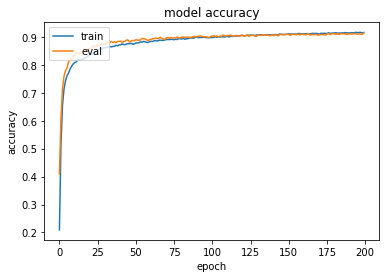

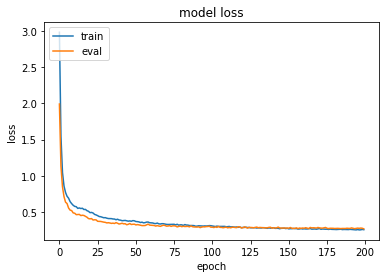

In [51]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()